How to Forecast with Python Using SARIMA

In this post, my goal is to give a quick tutorial on how to implement the SARIMA (Seasonal Autoregressive Integrated Moving Average) model to forecast seasonal data using python in Jupyter notebook. If you wish to follow along, please download the the data and code from my GitHub account.

Dataset

According to the U.S. Energy Information Administration, this data captures the monthly net electricity generation from coal in the country. The numbers are in Kilowatthours. 

The goal of this exercise is to build a SARIMA model to forecast values till 2030.

Importing Dependencies

Now, let's start creating the model by importing various libraries in Jupyter notebook that would make our job easier such as numpy, pandas, matplotlib, sklearn, itertools, warnings and statsmodels.

In [143]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error
%matplotlib inline
import itertools
import warnings
plt.style.use('ggplot')

Loading Data

In the first step, we will load the dataset using pandas and check the first five elements of the datasheet i.e. head of the dataset.

In [169]:
#Import data from EIA - Weekly Natural Gas Storage Report
data = pd.read_csv('Electricity_Net_Generation_From_Coal_Electric_Power_Sector_Monthly.csv')
data.head()

,Date,Electricity
0,Mar-21,61560.817
1,Feb-21,87393.033
2,Jan-21,81340.130
3,Dec-20,78215.003
4,Nov-20,60895.921


Visualizing Dataset

Let's visualize the electricity net generation between 1973 and 2021. The code for producing this visualization is as follows:

<Figure size 864x360 with 0 Axes>

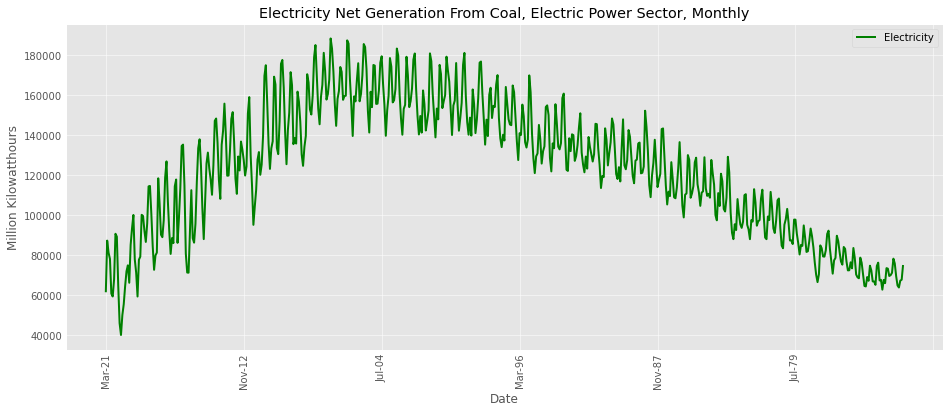

In [170]:
#Visualize net electricity generation from coal since 1973
plt.figure(figsize=[12, 5]); # Set dimensions for figure
data.plot(x='Date', y='Electricity', figsize = (14, 6), legend = True, color='g')
plt.title('Electricity Net Generation From Coal, Electric Power Sector, Monthly')
plt.ylabel('Million Kilowatthours')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

Testing the Stationarity of the Dataset

Let us use the Augmented Dickey-Fuller Test, a well known statistical test that can help determine if the time series is stationary. The ADF test is a type of unit root test. Unit roots are a cause for non-stationarity, the ADF test will test if the unit root is present. The Null Hypothesis states there is the presence of a unit root. If the P-Value is less than the Significance Level defined, we reject the Null Hypothesis that the time series contains a unit root. In other words, by rejecting the Null hypothesis, we can conclude that the time series is stationary.

In [172]:
# Augmented Dickey-Fuller test (ADF Test)
ad_fuller_result = adfuller(data['Electricity'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.8553039839614727
p-value: 0.8023350580171775


Differencing

Since the series isn't stationary, we will commit to the first order differencing of electricity values and perform ADF test again on the dataset.

In [173]:
data['Electricity First Difference'] = data['Electricity'] - data['Electricity'].shift(1)
data.dropna(subset = ["Electricity First Difference"], inplace=True)
data.head()

,Date,Electricity,Electricity First Difference
1,Feb-21,87393.033,25832.216
2,Jan-21,81340.130,-6052.903
3,Dec-20,78215.003,-3125.127
4,Nov-20,60895.921,-17319.082
5,Oct-20,59440.229,-1455.692


In [174]:
ad_fuller_result = adfuller(data['Electricity First Difference'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.18567304668538
p-value: 6.298214246510882e-08


Visualize Differenced Series 

The p-value is now less than 0.05, meaning that we can reject the null hypothesis i.e. the time series is stationary. Next, let us visualize the differenced series.

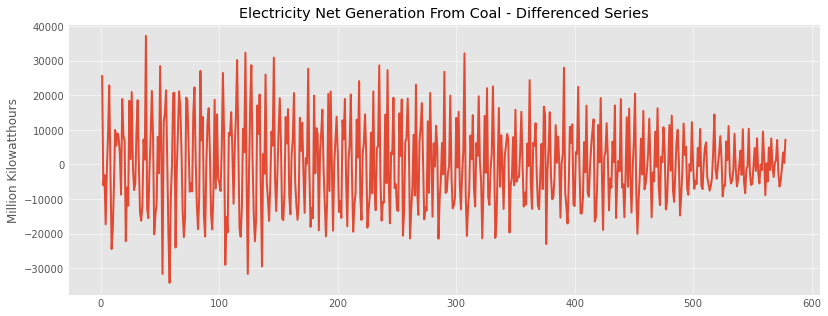

In [179]:
plt.figure(figsize=[12, 5]); # Set dimensions for figure
data['Electricity First Difference'].plot()
plt.title('Electricity Net Generation From Coal - Differenced Series')
plt.ylabel('Million Kilowatthours')
plt.grid(True)

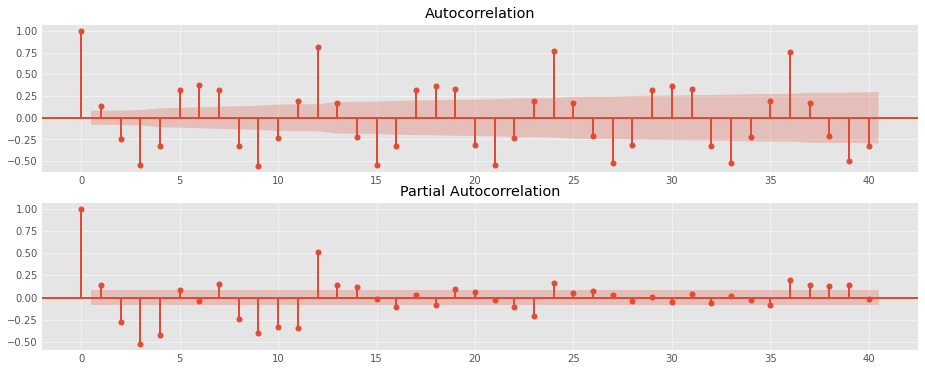

In [155]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Electricity First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Electricity First Difference'].dropna(),lags=40,ax=ax2)

SARIMA Model

After determining that our time series is stationary, we can use the SARIMA model to predict future values. The model's notation is SARIMA(p, d, q) (P, D, Q)lag. These three parameters account for seasonality, trend, and noise in data. We will use the AIC (Akaike information criterion) indicator which is an estimator of the relative quality of statistical models. The lower the AIC value the better. After performing multiple iterations, the model suggests that SARIMAX(2, 1, 2)x(2, 1, 2, 12) with AIC value of 11379 is the best combination.

In [175]:
best_model = SARIMAX(data['Electricity'], order=(2, 1, 2), seasonal_order=(2, 1, 2, 12)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        Electricity   No. Observations:                  578
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -5680.804
Date:                            Thu, 22 Jul 2021   AIC                          11379.609
Time:                                    13:52:47   BIC                          11418.640
Sample:                                         0   HQIC                         11394.844
                                            - 578                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3578      0.568     -0.630      0.529      -1.471       0.756
ar.L2          0.4272      0.250   

After we have fitted the model to the data, we check the residual plots to verify the validity of the model fit. A good forecasting method will have minimal information left in the residuals if any.

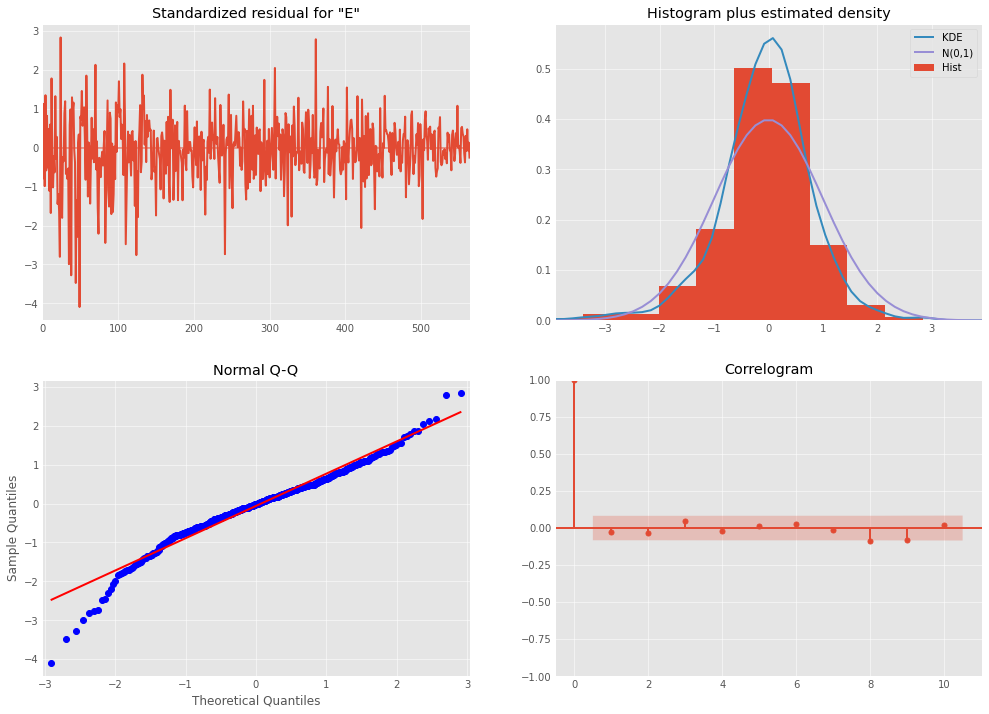

In [152]:
#Diagnosing the model residuals
best_model.plot_diagnostics(figsize=(15,12));

The correlogram on the bottom right suggests that there is no autocorrelation in the residuals, and so they are effectively white noise. Therefore, these residuals are uncorrelated and have close to zero mean.

Model Forecast

In the forecast step, we will try to predict the electricity generation data for the next 160 steps or 10 years. The graph below shows a good fit compared to historical data.

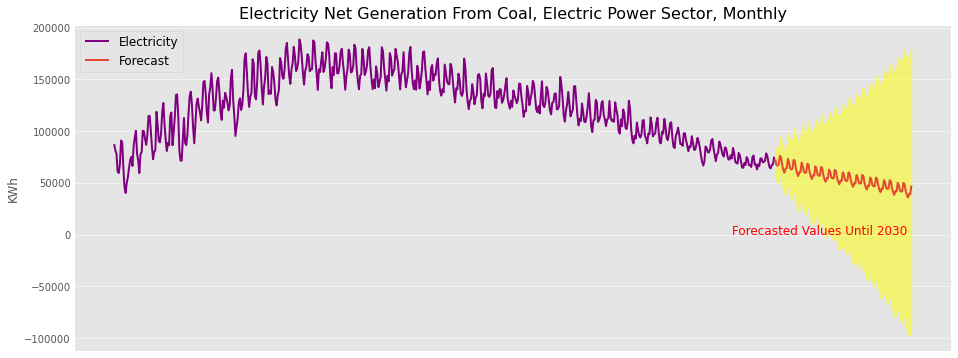

In [178]:
#Forecasting 3 years steps ahead
forecast_values = best_model.get_forecast(steps = 120)

#Confidence intervals of the forecasted values
forecast_ci = forecast_values.conf_int()

#Plot the data
ax = data.plot(x='Date', y='Electricity', figsize = (14, 6), legend = True, color='purple')

#Plot the forecasted values 
forecast_values.predicted_mean.plot(ax=ax, label='Forecast', figsize = (14, 6), grid=True)

#Plot the confidence intervals
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[: , 0],
                forecast_ci.iloc[: , 1], color='yellow', alpha = .5)
plt.title('Electricity Net Generation From Coal, Electric Power Sector, Monthly', size = 16)
plt.ylabel('KWh', size=12)
plt.legend(loc='upper left', prop={'size': 12})
ax.axes.get_xaxis().set_visible(False)
#annotation
ax.text(540, 400, 'Forecasted Values Until 2030', fontsize=12,  color='red')
plt.show()

In [166]:
#divide into train and validation set to calculate R-squared score and mean absolute percentage error 
train = data[:int(0.85*(len(data)))]
test = data[int(0.85*(len(data))):]
start=len(train)
end=len(train)+len(test)-1
predictions = best_model.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['Electricity'], predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['Electricity'], predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test['Electricity'], predictions)
evaluation_results['root_mean_squared_error'] = np.sqrt(mean_squared_error(test['Electricity'], predictions))
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test['Electricity'])
                                                               /np.abs(test['Electricity']))*100 
evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error
0,0.883725,2573.325129,1.078484e+07,3284.027748,3.258619
